In [12]:
import os
from datasets import load_dataset
import torch
import torchaudio
from transformers import AutoProcessor, AutoModel
import numpy as np
from panns_inference import AudioTagging

In [ ]:

# Load the dataset
dataset = load_dataset("lewtun/music_genres_small")

# Check a sample

samples = dataset['train'][0]
print(samples)

{'audio': {'path': None, 'array': array([-3.29642924e-10, -4.74537076e-10,  1.09266698e-08, ...,
       -2.98384890e-01, -3.06825116e-01, -2.82902196e-01]), 'sampling_rate': 44100}, 'song_id': 11704, 'genre_id': 6, 'genre': 'Chiptune / Glitch'}


In [30]:
# Load PANNs model (Cnn14)
model = AudioTagging(checkpoint_path=None, device='cuda')  # Use 'cuda' if you have a GPU

def extract_embeddings(audio_sample):
    """Extract embeddings from a dataset sample."""
    waveform = torch.tensor(audio_sample["audio"]["array"]).float().unsqueeze(0).to("cuda")  # Convert to FloatTensor & move to GPU
    with torch.no_grad():
        embedding, _ = model.inference(waveform)  # ✅ Unpack tuple: (embedding, class_probabilities)
    return embedding  # ✅ Returns the correct feature embeddings

def extract_and_save_embeddings(dataset, save_path="embeddings-for-instruments-task.npy"):
    embeddings = []
    for sample in dataset:
        embeddings.append(extract_embeddings(sample))
    np.save(save_path, np.array(embeddings))
    return save_path

embedding_file = extract_and_save_embeddings(dataset['train'])



Checkpoint path: C:\Users\Prosp/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [37]:
# Load embeddings
embeddings = np.load("embeddings-for-instruments-task.npy")

# Remove the extra dimension
embeddings = np.squeeze(embeddings)  # Shape will become (1000, 527)

# Check new shape
print(embeddings.shape)  # Should print (1000, 527)

(1000, 527)


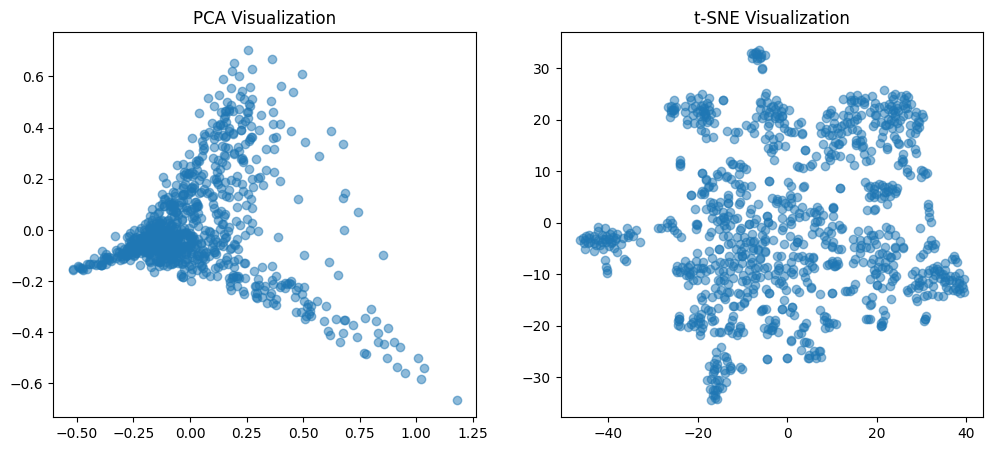

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load embeddings
embeddings = np.squeeze(np.load("embeddings-for-instruments-task.npy"))  # Shape: (num_samples, embedding_dim)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization")

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Visualization")

plt.show()
